In [1]:
import polars as pl
import matplotlib.pyplot as plt
from utils import create_trips_df

In [2]:
def time_to_next_stop(trips_df:pl.DataFrame, is_daytime:bool = True, ):
    
    if is_daytime:
        trips_df = trips_df.filter(pl.col('bus_stop_time').dt.hour().is_between(6, 20))

    trips_df = trips_df.sort(by=['trip_id', 'bus_stop_time'])
    trips_df = trips_df.with_columns(time_to_previous_stop =
        (pl.col("bus_stop_time") -pl.col("bus_stop_time").shift(1))
        .over(pl.col("trip_id").rle_id()))
    
    trips_df = trips_df.with_columns(pl.col("time_to_previous_stop").fill_null(strategy="zero"))

    trips_df = trips_df.with_columns(cum_trip_time =
        pl.cum_sum("time_to_previous_stop")
        .over(pl.col("trip_id").rle_id()))
    
    trips_df = trips_df.with_columns(stop_sequence = (
        pl.col('bus_stop_time').rank("ordinal")
        .over(pl.struct(['trip_id', 'pid']).rle_id())))


    trips_df = trips_df.with_columns((pl.col('bus_stop_time').dt.hour()).alias('hour'), 
                      (pl.col('bus_stop_time').dt.month()).alias('month'),
                      (pl.col('bus_stop_time').dt.year()).alias('year'),
                        (pl.col('bus_stop_time').dt.day()).alias('day'))

    return trips_df


def group_metrics(trips_df:pl.DataFrame, group_type:str, metric:str):

    if group_type == 'bus_stop':
        group_type = ['pid', 'stop_id']
    else:
        group_type = [group_type]

    trips_df = trips_df.group_by(['rt',*group_type]).agg(
            median = pl.median(metric),
            mean = pl.mean(metric),
            max = pl.max(metric),
            min = pl.min(metric),
            std = pl.std(metric),
            q25 = pl.col(metric).quantile(0.25),
            q75 = pl.col(metric).quantile(0.75),
    )
    
    return trips_df.sort(['rt',*group_type])


def find_metric(is_schedule:bool, metric:str, rts:list, group_type:str = 'stop_id'):
    """
    Calculate a metric for the given rts for other real bus locations of from the schedule.
    """

    rt_to_pid = pl.read_parquet('rt_to_pid.parquet')

    trips_df = create_trips_df(rt_to_pid, rts = rts, is_scheduled=is_schedule)

    if metric == 'time_to_next_stop':
        return time_to_next_stop(trips_df,group_type = group_type)

def chart_schedule_vs_real(schedule, real, groupby):

    fig, ax = plt.subplots()
    ax.plot(schedule[groupby], schedule['median'], label = 'Schedule')
    ax.plot(real[groupby], real['median'], label = 'Real')

    ax.legend()
    plt.show()

    


In [ ]:
test = 

In [109]:
rt_to_pid = pl.read_parquet('rt_to_pid.parquet')

#median for schedule
schd_trips_df = create_trips_df(rt_to_pid, rts = ['55'], is_scheduled=True)
test = time_to_next_stop(schd_trips_df)
schedule_metrics = group_metrics(test, 'bus_stop', 'cum_trip_time')

test_schedule = schedule_metrics.filter(pl.col('pid') == '5425').sort('median')

#median for real
trips_df = create_trips_df(rt_to_pid, rts = ['55'], is_scheduled=False)
bus_trips = time_to_next_stop(trips_df)
bus_metrics = group_metrics(bus_trips, 'bus_stop', 'cum_trip_time')

test_bus = bus_metrics.filter(pl.col('pid') == 5425).sort('median')

#sample of 100 bus trips
sample_trips = bus_trips.filter(pl.col('pid') == 5425).select(pl.col('trip_id')).sample(100)
bus_trips_sample = bus_trips.filter(pl.col('trip_id').is_in(sample_trips))

Do not have pattern 20424 for route. Skipping


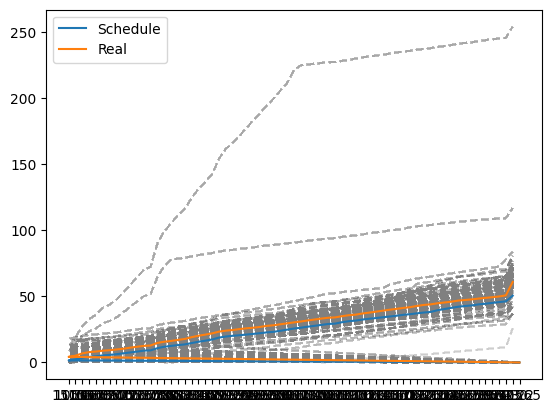

<Figure size 1000x1000 with 0 Axes>

In [118]:

fig, ax = plt.subplots()
plt.figure(figsize=(10,10))

#for trip in range(bus_trips_sample.select('trip_id').unique()):
    #subset = bus_trips_sample.slice(i,1)


for row in bus_trips_sample.iter_rows(named=True):
    subset = bus_trips_sample.filter(pl.col('trip_id') == row['trip_id'])
    ax.plot(subset['stop_id'], subset.select(pl.col('cum_trip_time')).get_columns()[0].dt.total_seconds()/60, color = 'grey', alpha=0.01, linestyle='dashed')

ax.plot(test_schedule['stop_id'], test_schedule.select(pl.col('median')).get_columns()[0].dt.total_seconds()/60, label = 'Schedule')
ax.plot(test_bus['stop_id'], test_bus.select(pl.col('median')).get_columns()[0].dt.total_seconds()/60, label = 'Real')

ax.legend()
plt.show()
